# Adaptive Linear Neuron (ADALINE)

### Download Iris dataset
Follow the link and download the Iris dataset:  
http://archive.ics.uci.edu/ml/machine-learning-databases/iris/

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.utils as skutils
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
class Adaline:

    def __init__(self, init='mini-batch', alpha=0.0001, epsilon=0.1, max_iter=300):
        self.init = init
        self.alpha = alpha
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.intercept_ = None
        self.coef_ = None
        self.iter = None

    def fit(self, X, y, batch_size=None):
        X = np.array(X)
        y = y.reshape(-1, 1)
        self.intercept_ = np.random.normal(loc=0, scale=0.01)
        self.coef_ = np.random.normal(loc=0, scale=0.01, size=(len(X.T), 1))
        self.iter = 0

        if self.init == 'mini-batch':
            self._mini_batch(X, y, batch_size)
        else:
            self._batch(X, y)
                
        return self

    def _create_batches(self, X, y, batch_size):
        Xb, yb = skutils.shuffle(X, y)
        batches = (int)(len(X) / (batch_size or len(X)))
        Xb = np.array_split(Xb, batches)
        yb = np.array_split(yb, batches)
        return zip(Xb, yb)
    
    def _mini_batch(self, X, y, batch_size):
        while True:
            self.iter += 1
            if self.iter > self.max_iter:
                break
            
            old_cost = self._cost(X, y)

            for Xb, yb in self._create_batches(X, y, batch_size):     
                e = np.ones(len(Xb))
                z = self._z(Xb)
                y_cap = self._phi(z)

                delta_b = -self.alpha * -e.dot(yb - y_cap)
                delta_w = -self.alpha * -Xb.T.dot(yb - y_cap)
                self.intercept_ += delta_b
                self.coef_ += delta_w
            
            new_cost = self._cost(X, y)
            if abs(new_cost - old_cost) < self.epsilon:
                break
    
    def _batch(self, X, y):
        while True:
            self.iter += 1
            if self.iter > self.max_iter:
                break

            e = np.ones(len(X))
            z = self._z(X)
            y_cap = self._phi(z)
            
            delta_b = -self.alpha * -e.dot(y - y_cap)
            delta_w = -self.alpha * -X.T.dot(y - y_cap)
            self.intercept_ += delta_b
            self.coef_ += delta_w
            
            if (delta_b ** 2) + (delta_w ** 2).sum() < self.epsilon:
                break
    
    def _cost(self, X, y):
        z = self._z(X)
        y_cap = self._phi(z)
        return ((y - y_cap) ** 2).sum() / 2
    
    # weighted input function
    def _z(self, X):
        return X.dot(self.coef_) + self.intercept_
    
    # activation functions
    def _phi(self, z):
        return z

    # quantizer
    def _q(self, a):
        return np.where(a < 0, -1, 1).reshape(1, -1)[0]
    
    def predict(self, X):
        z = self._z(X)
        y_cap = self._phi(z)
        return self._q(y_cap)
    
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

## Import

In [3]:
X = pd.read_csv('datasets/iris.data.csv')
X = X[X['class'].isin(['Iris-setosa', 'Iris-versicolor'])]
X['class'] = np.where(X['class'] == 'Iris-setosa', -1, 1)

In [4]:
x_fields = ['sepal length', 'petal width']

## Without standardisation

### Slicing

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X[x_fields], np.array(X['class']), test_size=0.2)

### Fitting

In [6]:
model = Adaline(alpha=0.0005, epsilon=0.0001).fit(X_train, y_train)

### Performance

In [7]:
print('total iterations', model.iter)
print('train set accuracy', model.score(X_train, y_train))
print('test set accuracy', model.score(X_test, y_test))

total iterations 301
train set accuracy 1.0
test set accuracy 1.0


### Scatterplot

#### train set

In [8]:
x=np.array(X_train).T[0]
y=np.array(X_train).T[1]

In [9]:
hue=np.where(model.predict(X_train) == -1, 'Iris-setosa', 'Iris-versicolor')

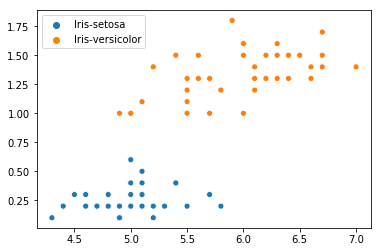

In [10]:
sns.scatterplot(x=x, y=y, hue=hue)

#### test set

In [11]:
x=np.array(X_test).T[0]
y=np.array(X_test).T[1]

In [12]:
hue=np.where(model.predict(X_test) == -1, 'Iris-setosa', 'Iris-versicolor')

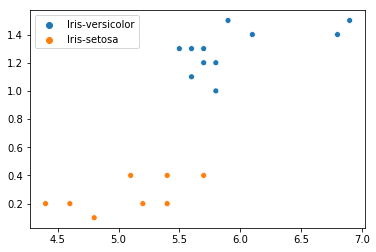

In [13]:
sns.scatterplot(x=x, y=y, hue=hue)

## With standardisation

### Preprocessing

In [14]:
X[x_fields] = StandardScaler().fit_transform(X[x_fields])

### Slicing

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X[x_fields], np.array(X['class']), test_size=0.2)

### Batch

#### Fitting

In [16]:
model = Adaline(init='batch', alpha=0.01, epsilon=0.01).fit(X_train, y_train)

#### Performance

In [17]:
print('total iterations', model.iter)
print('train set accuracy', model.score(X_train, y_train))
print('test set accuracy', model.score(X_test, y_test))

total iterations 5
train set accuracy 1.0
test set accuracy 1.0


### Mini-Batch

#### Fitting

In [18]:
model = Adaline(init='mini-batch', alpha=0.1).fit(X_train, y_train, batch_size=4)

#### Performance

In [19]:
print('total iterations', model.iter)
print('train set accuracy', model.score(X_train, y_train))
print('test set accuracy', model.score(X_test, y_test))

total iterations 3
train set accuracy 1.0
test set accuracy 1.0


### Stochastic

#### Fitting

In [20]:
model = Adaline(init='mini-batch', alpha=0.1).fit(X_train, y_train, batch_size=1)

#### Performance

In [21]:
print('total iterations', model.iter)
print('train set accuracy', model.score(X_train, y_train))
print('test set accuracy', model.score(X_test, y_test))

total iterations 2
train set accuracy 1.0
test set accuracy 1.0


### Scatterplot

#### train set

In [22]:
x=np.array(X_train).T[0]
y=np.array(X_train).T[1]

In [23]:
hue=np.where(model.predict(X_train) == -1, 'Iris-setosa', 'Iris-versicolor')

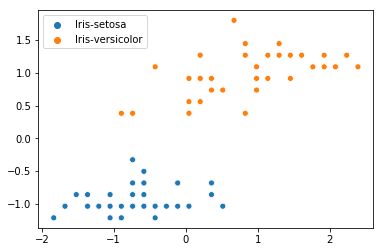

In [24]:
sns.scatterplot(x=x, y=y, hue=hue)

#### test set

In [25]:
x=np.array(X_test).T[0]
y=np.array(X_test).T[1]

In [26]:
hue=np.where(model.predict(X_test) == -1, 'Iris-setosa', 'Iris-versicolor')

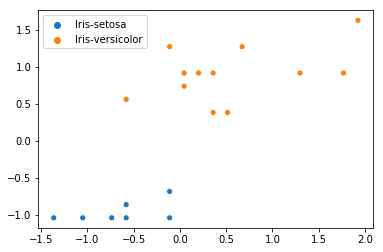

In [27]:
sns.scatterplot(x=x, y=y, hue=hue)

## Linearly inseparable classes

In [28]:
X = pd.read_csv('datasets/iris.data.csv')
X = X[X['class'].isin(['Iris-virginica', 'Iris-versicolor'])]
X['class'] = np.where(X['class'] == 'Iris-virginica', -1, 1)

In [29]:
x_fields = ['sepal length', 'sepal width']

### Preprocessing

In [30]:
X[x_fields] = StandardScaler().fit_transform(X[x_fields])

### Slicing

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X[x_fields], np.array(X['class']), test_size=0.2)

### Fitting

In [32]:
model = Adaline(alpha=0.01, epsilon=0.01).fit(X_train, y_train)

### Performance

In [33]:
print('total iterations', model.iter)
print('train set accuracy', accuracy_score(y_train, model.predict(X_train)))
print('test set accuracy', accuracy_score(y_test, model.predict(X_test)))

total iterations 8
train set accuracy 0.725
test set accuracy 0.75


### Scatterplot predicted

#### train set

In [34]:
x=np.array(X_train).T[0]
y=np.array(X_train).T[1]

In [35]:
hue=np.where(model.predict(X_train) == -1, 'Iris-virginica', 'Iris-versicolor')

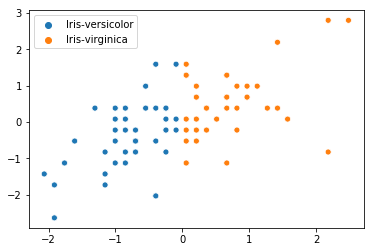

In [36]:
sns.scatterplot(x=x, y=y, hue=hue)

#### test set

In [37]:
x=np.array(X_test).T[0]
y=np.array(X_test).T[1]

In [38]:
hue=np.where(model.predict(X_test) == -1, 'Iris-virginica', 'Iris-versicolor')

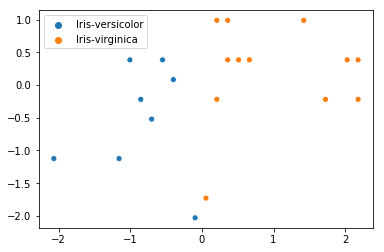

In [39]:
sns.scatterplot(x=x, y=y, hue=hue)

### Scatterplot actual

#### train set

In [40]:
x=np.array(X_train).T[0]
y=np.array(X_train).T[1]

In [41]:
hue=np.where(y_train == -1, 'Iris-virginica', 'Iris-versicolor')

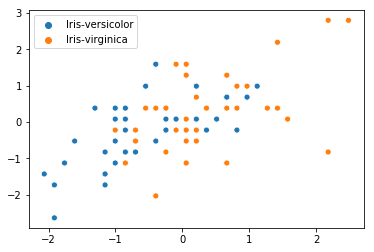

In [42]:
sns.scatterplot(x=x, y=y, hue=hue)

#### test set

In [43]:
x=np.array(X_test).T[0]
y=np.array(X_test).T[1]

In [44]:
hue=np.where(y_test == -1, 'Iris-virginica', 'Iris-versicolor')

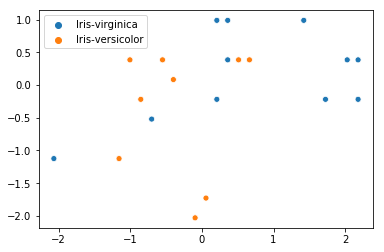

In [45]:
sns.scatterplot(x=x, y=y, hue=hue)